In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

In [2]:
# ============================================================
# 0. Extra imports (run once near the top of the notebook)
# ============================================================
import networkx as nx, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import ks_2samp, spearmanr
from sklearn.metrics import normalized_mutual_info_score

# community-louvain (pip install python-louvain)
import community as cl          #  import community_louvain as cl  (if newer alias)

# optional: NetLSD for graph signatures (pip install netlsd)
try:
    from netlsd import NetLSD
except ImportError:
    NetLSD = None

### Perturbed sonia attack

In [32]:
import pickle as pkl
import numpy as np
import networkx as nx
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt

def parse_index_file(filename):
    """Parse test.index file."""
    with open(filename) as f:
        return [int(line.strip()) for line in f]

def load_graph_and_labels(path="data/cora/raw/", dataset="cora"):
    # Load graph
    with open(f"{path}ind.{dataset}.graph", "rb") as f:
        graph = pkl.load(f, encoding='latin1')
    G = nx.from_dict_of_lists(graph)

    # Load label data
    with open(f"{path}ind.{dataset}.allx", "rb") as f:
        allx = pkl.load(f, encoding='latin1')  # features + labels (train)
    with open(f"{path}ind.{dataset}.ally", "rb") as f:
        ally = pkl.load(f, encoding='latin1')  # labels (test)
    test_idx = parse_index_file(f"{path}ind.{dataset}.test.index")

    # Reorder test_idx to be in full range
    test_idx_sorted = np.sort(test_idx)
    total_len = allx.shape[0] + len(test_idx)
    
    # Build full label matrix (train + test)
    full_labels = np.zeros((total_len, ally.shape[1]))
    full_labels[:allx.shape[0]] = allx[:, -ally.shape[1]:].toarray()  # labels from allx
    for i, idx in enumerate(test_idx):
        full_labels[idx] = ally[i]

    class_indices = np.argmax(full_labels, axis=1)

    # Build label_dict using actual node ids from the graph
    label_dict = {node_id: class_indices[node_id] for node_id in graph.keys()}

    return G, label_dict

# Load data
G_original, label_dict = load_graph_and_labels()


In [10]:
# Load perturbed graph from perturbed_content.csv and perturbed_edges.csv
perturbed_edges = pd.read_csv('data/cora/perturbed/perturbed_edges.csv', header=None, names=['src', 'dst'])

G_perturbed = nx.Graph()
G_perturbed.add_edges_from(perturbed_edges.values)
print(f"Perturbed Graph: {G_perturbed.number_of_nodes()} nodes, {G_perturbed.number_of_edges()} edges")

Perturbed Graph: 2703 nodes, 5278 edges


### Perturbed Nettack

In [6]:
# import torch
# import networkx as nx

# # Load the file
# data_2 = torch.load('Cora_perturbed.pt')

# # Extract adjacency matrix
# adj = data_2['perturbed_adj']

# # If it's a sparse tensor, convert it to edge list
# if adj.is_sparse:
#     # Get indices (edges) from the sparse tensor
#     edge_index = adj.coalesce().indices()
#     edge_list = edge_index.t().tolist()
# else:
#     # If it's a dense tensor, convert to edge list by finding non-zero entries
#     edge_list = adj.nonzero(as_tuple=False).tolist()

# # Build the graph
# G_perturbed = nx.Graph()
# G_perturbed.add_edges_from(edge_list)

# print(f"Perturbed Graph: {G_perturbed.number_of_nodes()} nodes, {G_perturbed.number_of_edges()} edges")

# # Return G_perturbed
# G_perturbed


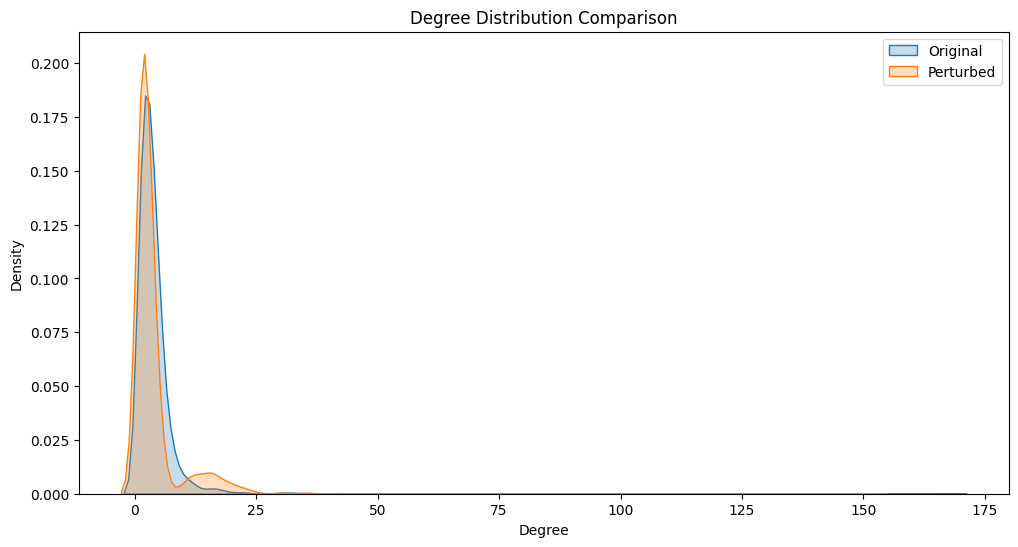

In [12]:
# Compute degrees
deg_orig = [d for n, d in G_original.degree()]
deg_pert = [d for n, d in G_perturbed.degree()]

# Plot
plt.figure(figsize=(12,6))
sns.kdeplot(deg_orig, label="Original", fill=True)
sns.kdeplot(deg_pert, label="Perturbed", fill=True)
plt.title("Degree Distribution Comparison")
plt.xlabel("Degree")
plt.ylabel("Density")
plt.legend()

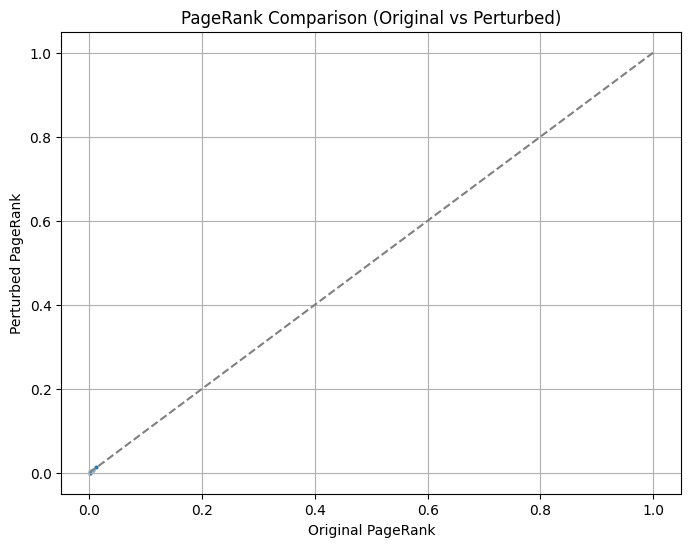

In [13]:
pr_orig = nx.pagerank(G_original)
pr_pert = nx.pagerank(G_perturbed)

# Merge PageRank into a dataframe
pr_df = pd.DataFrame({
    'Original': pd.Series(pr_orig),
    'Perturbed': pd.Series(pr_pert)
})

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='Original', y='Perturbed', data=pr_df, s=10)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("PageRank Comparison (Original vs Perturbed)")
plt.xlabel("Original PageRank")
plt.ylabel("Perturbed PageRank")
plt.grid(True)
plt.show()

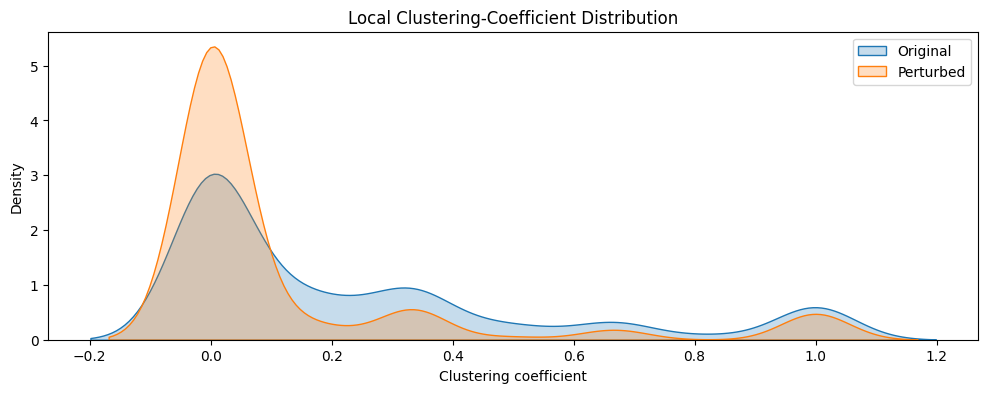

Global C_orig  = 0.2407
Global C_pert  = 0.1254


In [14]:
# --- Clustering coefficient -----------------------------------
cc_orig  = list(nx.clustering(G_original).values())
cc_pert  = list(nx.clustering(G_perturbed).values())

plt.figure(figsize=(12,4))
sns.kdeplot(cc_orig, label="Original", fill=True)
sns.kdeplot(cc_pert, label="Perturbed", fill=True)
plt.title("Local Clustering-Coefficient Distribution")
plt.xlabel("Clustering coefficient"); plt.legend(); plt.show()

print(f"Global C_orig  = {nx.average_clustering(G_original):.4f}")
print(f"Global C_pert  = {nx.average_clustering(G_perturbed):.4f}")

In [33]:
label_dict = data.y.numpy()  # labels from torch-geo
nx.set_node_attributes(G_original,  {i:int(label_dict[i]) for i in G_original}, 'y')
nx.set_node_attributes(G_perturbed,{i:int(label_dict[i]) for i in G_perturbed},'y')

r_orig = nx.attribute_assortativity_coefficient(G_original, 'y')
r_pert = nx.attribute_assortativity_coefficient(G_perturbed,'y')
print(f"Label assortativity:  orig={r_orig:.4f}   pert={r_pert:.4f}")


Label assortativity:  orig=0.7711   pert=0.3155


In [9]:
# # Ensure label array is in NumPy format
# labels = data_2['labels']
# if isinstance(labels, torch.Tensor):
#     label_array = labels.numpy()
# elif isinstance(labels, np.ndarray):
#     label_array = labels
# else:
#     raise TypeError("Unsupported label type")

# # Assign labels as node attributes
# nx.set_node_attributes(G_original,  {i: int(label_array[i]) for i in G_original.nodes}, 'y')
# nx.set_node_attributes(G_perturbed, {i: int(label_array[i]) for i in G_perturbed.nodes}, 'y')

# # Compute label assortativity
# r_orig = nx.attribute_assortativity_coefficient(G_original, 'y')
# r_pert = nx.attribute_assortativity_coefficient(G_perturbed, 'y')

# print(f"Label assortativity:  orig={r_orig:.4f}   pert={r_pert:.4f}")



Nodes with largest betweenness change: [2034, 1986, 2249, 109, 2130, 1013, 1072, 963, 306, 88]


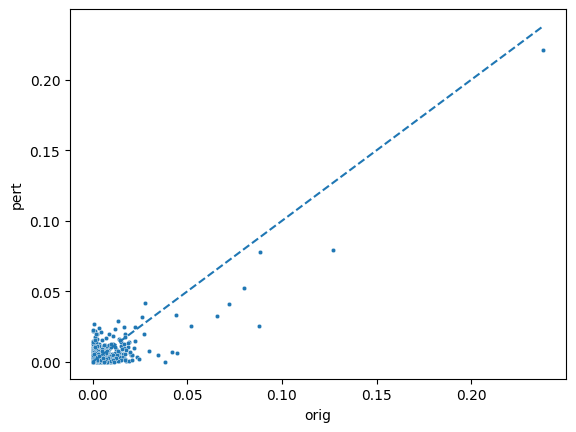

In [17]:
btw_o = nx.betweenness_centrality(G_original, k=500, seed=1)   # sample for speed
btw_p = nx.betweenness_centrality(G_perturbed, k=500, seed=1)

df_btw = pd.DataFrame({'orig':btw_o, 'pert':btw_p})
df_btw['delta'] = df_btw['pert'] - df_btw['orig']
top_shift = df_btw['delta'].abs().nlargest(10).index

print("Nodes with largest betweenness change:", top_shift.tolist())
sns.scatterplot(x='orig', y='pert', data=df_btw, s=10)
plt.plot([0, max(df_btw.max())], [0, max(df_btw.max())],'--'); plt.show()

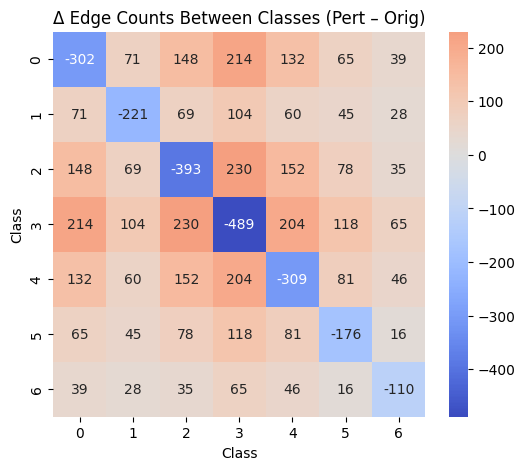

In [36]:
def class_mix(G, labels):
    m = len(np.unique(labels))
    M = np.zeros((m,m), dtype=int)
    for u,v in G.edges():
        M[labels[u], labels[v]] += 1
        if labels[u]!=labels[v]:
            M[labels[v], labels[u]] += 1
    return M

mix_o = class_mix(G_original, label_dict)
mix_p = class_mix(G_perturbed, label_dict)

delta = mix_p - mix_o
plt.figure(figsize=(6,5))
sns.heatmap(delta, cmap='coolwarm', center=0, annot=True, fmt='d')
plt.title("Δ Edge Counts Between Classes (Pert – Orig)")
plt.xlabel("Class"); plt.ylabel("Class"); plt.show()


In [19]:
def get_lcc(G):
    """Return the subgraph induced by the largest connected component."""
    comp = max(nx.connected_components(G), key=len)
    return G.subgraph(comp).copy()

G0_lcc = get_lcc(G_original)
Gp_lcc = get_lcc(G_perturbed)

def approx_dist_stats(G, k=2000, seed=42):
    rng   = np.random.RandomState(seed)
    nodes = list(G.nodes())
    pairs = [tuple(rng.choice(nodes, 2, replace=False)) for _ in range(k)]
    dists = [nx.shortest_path_length(G, *p) for p in pairs]
    return np.mean(dists), np.percentile(dists, 95)

avg_o, p95_o = approx_dist_stats(G0_lcc)
avg_p, p95_p = approx_dist_stats(Gp_lcc)

print(f"LCC - mean dist  : orig={avg_o:.2f}  pert={avg_p:.2f}")
print(f"LCC - 95-percent.: orig={p95_o:.2f}  pert={p95_p:.2f}")

LCC - mean dist  : orig=6.28  pert=6.03
LCC - 95-percent.: orig=10.00  pert=10.00


In [20]:
def approx_dist_stats_skip(G, k=2000, seed=42):
    rng   = np.random.RandomState(seed)
    nodes = list(G.nodes())
    dists = []
    while len(dists) < k:
        u, v = rng.choice(nodes, 2, replace=False)
        try:
            dists.append(nx.shortest_path_length(G, u, v))
        except nx.NetworkXNoPath:
            continue        # just resample
    return np.mean(dists), np.percentile(dists, 95)

avg_o, p95_o = approx_dist_stats_skip(G_original)
avg_p, p95_p = approx_dist_stats_skip(G_perturbed)
print(f"Mean shortest-path (skip): orig={avg_o:.2f}  pert={avg_p:.2f}")

Mean shortest-path (skip): orig=6.36  pert=6.12


In [21]:
def approx_dist_stats_inf(G, k=2000, seed=42, inf=1e9):
    rng   = np.random.RandomState(seed)
    nodes = list(G.nodes())
    pairs = [tuple(rng.choice(nodes, 2, replace=False)) for _ in range(k)]
    d = []
    for u, v in pairs:
        try:
            d.append(nx.shortest_path_length(G, u, v))
        except nx.NetworkXNoPath:
            d.append(inf)
    return np.mean(d), np.percentile(d, 95)

avg_o, p95_o = approx_dist_stats_inf(G_original)
avg_p, p95_p = approx_dist_stats_inf(G_perturbed)
print(f"Mean shortest-path (∞): orig={avg_o:.2f}  pert={avg_p:.2f}")


Mean shortest-path (∞): orig=157500005.38  pert=143500005.23


In [22]:
# ---------------------------------------------------------------
# Betweenness centrality comparison (original vs perturbed)
# ---------------------------------------------------------------
import time
from tqdm.auto import tqdm

# ► 1) choose fast sampling or full exact computation
SAMPLE = 800        # set to None to compute exact betweenness for every node
SEED   = 1

def betweenness(G, sample=None, seed=SEED):
    if sample is None:
        return nx.betweenness_centrality(G, normalized=True)
    rng   = np.random.default_rng(seed)
    nodes = rng.choice(list(G.nodes()), size=sample, replace=False)
    return nx.betweenness_centrality(G, k=sample, normalized=True, seed=seed)

print("Computing betweenness …")
btw_orig = betweenness(G_original,  SAMPLE)
btw_pert = betweenness(G_perturbed, SAMPLE)

Computing betweenness …


In [37]:
import networkx as nx

# Degree centrality
deg_orig  = nx.degree_centrality(G_original)
deg_pert  = nx.degree_centrality(G_perturbed)

# Closeness centrality
close_orig = nx.closeness_centrality(G_original)
close_pert = nx.closeness_centrality(G_perturbed)

# Eigenvector centrality (can raise errors if graph is disconnected)
eig_orig = nx.eigenvector_centrality(G_original, max_iter=1000)
eig_pert = nx.eigenvector_centrality(G_perturbed, max_iter=1000)

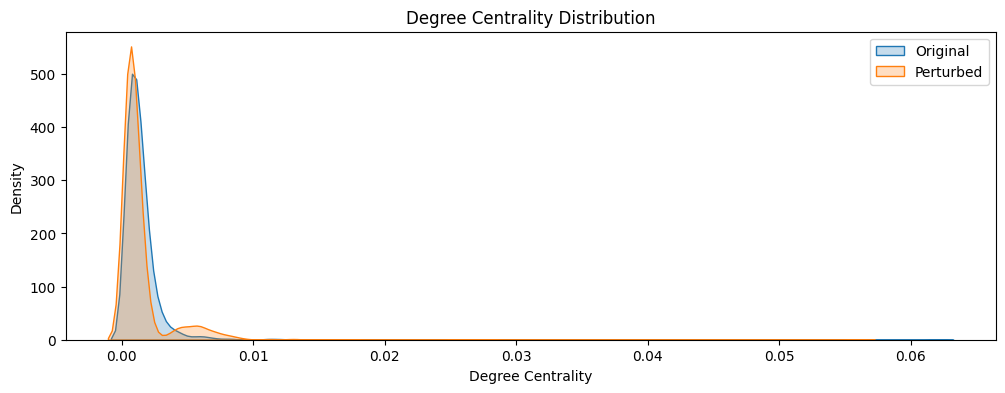

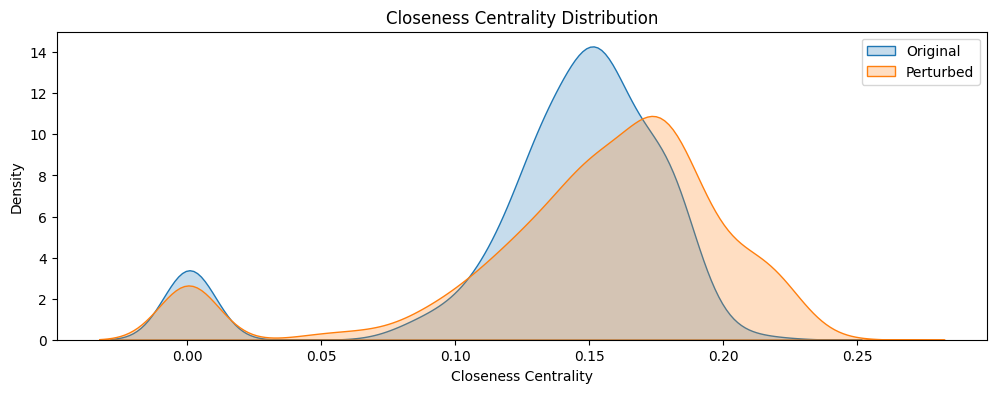

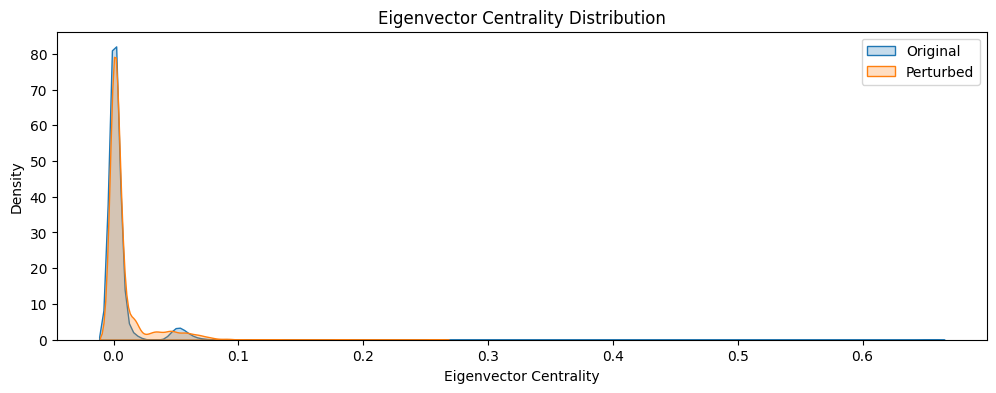

In [38]:
def plot_metric(metric_orig, metric_pert, title, xlabel):
    vals_orig = np.array([metric_orig[n] for n in sorted(metric_orig)])
    vals_pert = np.array([metric_pert[n] for n in sorted(metric_pert)])

    plt.figure(figsize=(12,4))
    sns.kdeplot(vals_orig, label="Original", fill=True)
    sns.kdeplot(vals_pert, label="Perturbed", fill=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Example usage:
plot_metric(deg_orig, deg_pert, "Degree Centrality Distribution", "Degree Centrality")
plot_metric(close_orig, close_pert, "Closeness Centrality Distribution", "Closeness Centrality")
plot_metric(eig_orig, eig_pert, "Eigenvector Centrality Distribution", "Eigenvector Centrality")

Processing...
Done!


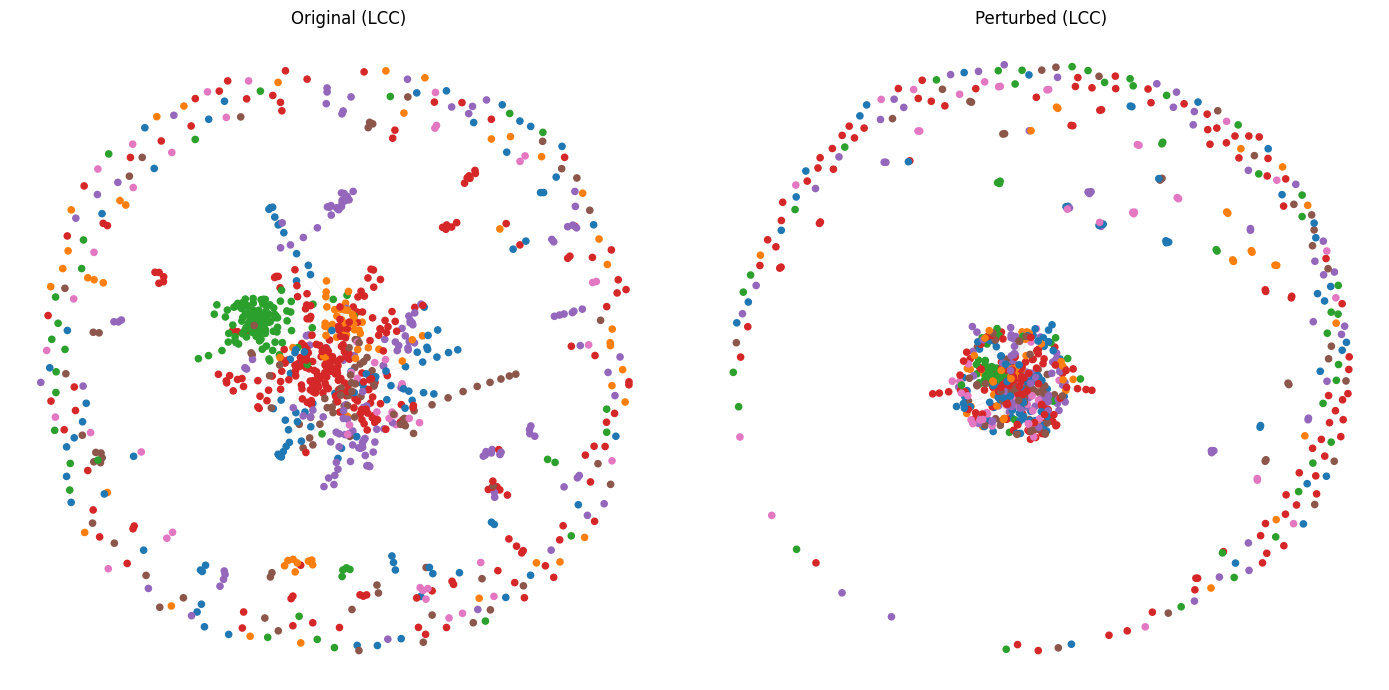

In [24]:
# Load original Planetoid Cora dataset
dataset = Planetoid(root='cora', name='Cora', split='public')
data = dataset[0]

G_original = nx.Graph()
edge_index = data.edge_index.numpy()
G_original.add_edges_from(edge_index.T)
labels = data.y.numpy()

# Load perturbed graph
perturbed_edges = pd.read_csv('data/cora/perturbed/perturbed_edges.csv', header=None, names=['src', 'dst'])
G_perturbed = nx.Graph()
G_perturbed.add_edges_from(perturbed_edges.values)

def sample_graph(G, n=None, seed=1):
    if n is None or n >= G.number_of_nodes():
        return G
    rng = np.random.default_rng(seed)
    keep = rng.choice(list(G.nodes()), size=n, replace=False)
    return G.subgraph(keep).copy()


# Prepare largest components
def lcc(G):
    comp = max(nx.connected_components(G), key=len)
    return G.subgraph(comp).copy()

G0 = lcc(G_original)
Gp = lcc(G_perturbed)
SUBSAMPLE = 1000
G0_draw = sample_graph(G0, SUBSAMPLE)
Gp_draw = sample_graph(Gp, SUBSAMPLE)

# Compute layout on original
pos = nx.spring_layout(G0_draw, seed=42)

# Patch layout for missing nodes in perturbed graph
missing = [n for n in Gp_draw if n not in pos]
if missing:
    pos_extra = nx.spring_layout(Gp_draw, seed=42, pos=pos, fixed=pos.keys())
    pos_p = {**pos, **{n: pos_extra[n] for n in missing}}
else:
    pos_p = pos

# Color nodes by class label
palette = plt.cm.tab10
def node_colors(nodes):
    return [palette(labels[n] % 10) for n in nodes]

# Draw side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
for ax, G, title, this_pos in [
        (axes[0], G0_draw, "Original (LCC)", pos),
        (axes[1], Gp_draw, "Perturbed (LCC)", pos_p)]:

    nx.draw_networkx_nodes(G, this_pos,
                           node_size=20,
                           node_color=node_colors(G.nodes()),
                           ax=ax)
    nx.draw_networkx_edges(G, this_pos,
                           width=0.3,
                           edge_color="lightgray",
                           alpha=0.7,
                           ax=ax)
    ax.set_title(title); ax.set_axis_off()

plt.tight_layout()

plt.show()


def sample_graph(G, n=None, seed=1):
    if n is None or n >= G.number_of_nodes():
        return G
    rng = np.random.default_rng(seed)
    keep = rng.choice(list(G.nodes()), size=n, replace=False)
    return G.subgraph(keep).copy()


In [25]:
# ------------------------------------------------------------
# 1A  How many edges were actually flipped?
# ------------------------------------------------------------
E_orig = set(G_original.edges());  E_pert = set(G_perturbed.edges())
added_edges   = E_pert - E_orig
removed_edges = E_orig - E_pert
print(f"{len(added_edges):,} edges added | {len(removed_edges):,} edges removed")

# ------------------------------------------------------------
# 1B  Kolmogorov–Smirnov test on key distributions
# ------------------------------------------------------------
def ks_report(x, y, label):
    D, p = ks_2samp(x, y)
    print(f"{label:12s}  KS-stat = {D:.4f}   p = {p:.3g}")

ks_report(deg_orig, deg_pert,          "Degree")
ks_report(list(pr_orig.values()), list(pr_pert.values()), "PageRank")

2,572 edges added | 2,572 edges removed
Degree        KS-stat = 0.1831   p = 4.19e-40
PageRank      KS-stat = 0.1068   p = 6.87e-14


In [26]:
# ------------------------------------------------------------
# 2.  Whole-graph connectivity summary
# ------------------------------------------------------------
def graph_summary(G):
    comps   = list(nx.connected_components(G))
    lcc     = max(comps, key=len)
    lcc_sub = G.subgraph(lcc)
    return dict(
        n           = G.number_of_nodes(),
        m           = G.number_of_edges(),
        components  = len(comps),
        LCC_size    = len(lcc),
        diameter    = nx.diameter(lcc_sub)      if len(lcc) < 5_000 else np.nan,
        efficiency  = nx.global_efficiency(G)
    )

for name, G in [("Original", G_original), ("Perturbed", G_perturbed)]:
    s = graph_summary(G)
    print(f"{name:<10} | V={s['n']:,}  E={s['m']:,}  comp={s['components']:,}  "
          f"LCC={s['LCC_size']:,}  diam={s['diameter']}  eff={s['efficiency']:.4f}")



Original   | V=2,708  E=5,278  comp=78  LCC=2,485  diam=19  eff=0.1496
Perturbed  | V=2,703  E=5,278  comp=78  LCC=2,505  diam=32  eff=0.1656


In [27]:
# ------------------------------------------------------------
# 3.  λ₂ (second smallest Laplacian eigenvalue)
# ------------------------------------------------------------
def lambda2(G):
    L = nx.laplacian_matrix(G, nodelist=sorted(G)).astype(float)
    eigs = np.linalg.eigvalsh(L.todense())
    return np.sort(eigs)[1]

print(f"λ₂ original  = {lambda2(G_original):.4f}")
print(f"λ₂ perturbed = {lambda2(G_perturbed):.4f}")

λ₂ original  = -0.0000
λ₂ perturbed = -0.0000


In [28]:
# ------------------------------------------------------------
# 4.  Louvain partition & modularity / NMI shift
# ------------------------------------------------------------
part_o = cl.best_partition(G_original, random_state=1)
part_p = cl.best_partition(G_perturbed, random_state=1)

mod_o = cl.modularity(part_o, G_original)
mod_p = cl.modularity(part_p, G_perturbed)

# align partitions for NMI (missing nodes get label –1)
labels_o = list(part_o.values())
labels_p = [part_p.get(v, -1) for v in part_o]  
nmi = normalized_mutual_info_score(labels_o, labels_p)

print(f"Modularity   : orig={mod_o:.4f}  pert={mod_p:.4f}")
print(f"Partition NMI: {nmi:.4f}")

Modularity   : orig=0.8153  pert=0.6350
Partition NMI: 0.5947
